In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
SEED = 42

train_df = pd.read_csv("/kaggle/input/jigsaw-agile-community-rules/train.csv")
test_df = pd.read_csv("/kaggle/input/jigsaw-agile-community-rules/test.csv")
sample_submission = pd.read_csv("/kaggle/input/jigsaw-agile-community-rules/sample_submission.csv")

print("train size: ", train_df.shape)
print("test size: ", test_df.shape)

2025-10-05 20:27:32.254841: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759696052.443352      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759696052.500308      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


train size:  (2029, 9)
test size:  (10, 8)


In [3]:
train_df.head(3)

,row_id,body,rule,subreddit,positive_example_1,positive_example_2,negative_example_1,negative_example_2,rule_violation
0,0,Banks don't want you to know this! Click here ...,"No Advertising: Spam, referral links, unsolici...",Futurology,If you could tell your younger self something ...,hunt for lady for jack off in neighbourhood ht...,Watch Golden Globe Awards 2017 Live Online in ...,"DOUBLE CEE x BANDS EPPS - ""BIRDS""\n\nDOWNLOAD/...",0
1,1,SD Stream [ ENG Link 1] (http://www.sportsstre...,"No Advertising: Spam, referral links, unsolici...",soccerstreams,[I wanna kiss you all over! Stunning!](http://...,LOLGA.COM is One of the First Professional Onl...,#Rapper \n🚨Straight Outta Cross Keys SC 🚨YouTu...,[15 Amazing Hidden Features Of Google Search Y...,0
2,2,Lol. Try appealing the ban and say you won't d...,No legal advice: Do not offer or request legal...,pcmasterrace,Don't break up with him or call the cops. If ...,It'll be dismissed: https://en.wikipedia.org/w...,Where is there a site that still works where y...,Because this statement of his is true. It isn'...,1


In [4]:
print('NA in train data:', train_df.isna().values.any())
print('NA in test data:', test_df.isna().values.any())

NA in train data: False
NA in test data: False


In [5]:
print('##### body #####')
print(train_df['body'].iloc[0,])
print('##### rule #####')
print(train_df['rule'].iloc[0,])
print('##### positive_example_1 #####')
print(train_df['positive_example_1'].iloc[0,])
print('#####  positive_example_2 #####')
print(train_df['positive_example_2'].iloc[0,])
print('##### negative_example_1 #####')
print(train_df['negative_example_1'].iloc[0,])
print('##### negative_example_2 #####')
print(train_df['negative_example_2'].iloc[0,])


##### body #####
Banks don't want you to know this! Click here to know more!
##### rule #####
No Advertising: Spam, referral links, unsolicited advertising, and promotional content are not allowed.
##### positive_example_1 #####
If you could tell your younger self something different about sex, what would that be?

i AM IN A CONTEST TO WIN FUNDING FOR MY SEX POSITIVE FILM: VOTE HERE:

http://sheknows.offerpop.com/campaign/813112/entry/v144417
#####  positive_example_2 #####
hunt for lady for jack off in neighbourhood http://url.inmusi.com/gakq
##### negative_example_1 #####
Watch Golden Globe Awards 2017 Live Online in HD Coverage without ADS (VIP STREAMS)
=

HD STREAM QUALITY >>> [WATCH LINK1](http://forum.submitexpress.com/viewtopic.php?f=9&t=215858)
=

HD BROADCASTING QUALITY >>> [WATCH LINK1](http://forum.submitexpress.com/viewtopic.php?f=9&t=215858)
=

Mobile Compatibility: YES
=

NO ADS | NO ADS | ADS
=

##### negative_example_2 #####
DOUBLE CEE x BANDS EPPS - "BIRDS"

DOWNLOAD/S

# Base-line test (BERT)

In [11]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [12]:
y = train_df["rule_violation"]
# X = train_df.drop(["rule_violation"], axis=1)
X = train_df["body"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=SEED)

In [13]:
# Token and Encode Function
def tokenize_and_encode(tokenizer, comments, labels, max_length=128):
    # Initialize empty lists to store tokenized inputs and attention masks
    input_ids = []
    attention_masks = []

    # Iterate through each comment in the 'comments' list
    for comment in comments:

        # Tokenize and encode the comment using the BERT tokenizer
        encoded_dict = tokenizer.encode_plus(
            comment,

            # Add special tokens like [CLS] and [SEP]
            add_special_tokens=True,

            truncation=True,
            
            # Truncate or pad the comment to 'max_length'
            max_length=max_length,

            # Pad the comment to 'max_length' with zeros if needed
            padding='max_length',

            # Return attention mask to mask padded tokens
            return_attention_mask=True,

            # Return PyTorch tensors
            return_tensors='pt'
        )

        # Append the tokenized input and attention mask to their respective lists
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    # Concatenate the tokenized inputs and attention masks into tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    # Convert the labels to a PyTorch tensor with the data type float32
    labels = torch.tensor(labels, dtype=torch.float32)

    # Return the tokenized inputs, attention masks, and labels as PyTorch tensors
    return input_ids, attention_masks, labels

In [9]:
# # Token Initialization
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# # Model Initialization
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)  # output = 1

In [10]:
# model.save_pretrained("my-bert-base-cls")
# tokenizer.save_pretrained("my-bert-base-cls")

In [14]:
MODEL_DIR = "/kaggle/input/my-base-bert/my-bert-cls"

tokenizer = BertTokenizer.from_pretrained(
    MODEL_DIR,
    do_lower_case=True,
    local_files_only=True
)

config = BertConfig.from_pretrained(
    MODEL_DIR,
    local_files_only=True
)

model = BertForSequenceClassification.from_pretrained(
    MODEL_DIR,
    config=config,
    local_files_only=True
)

In [15]:
# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

In [16]:
# Tokenize and Encode the comments and labels for the training set
input_ids, attention_masks, labels = tokenize_and_encode(
    tokenizer,
    X_train,
    y_train.values
)

# Tokenize and Encode the comments and labels for the validation set
val_input_ids, val_attention_masks, val_labels = tokenize_and_encode(
    tokenizer,
    X_val,
    y_val.values
)

print('Training Comments :',X_train.shape)
print('Input Ids         :',input_ids.shape)
print('Attention Mask    :',attention_masks.shape)
print('Labels            :',labels.shape)

Training Comments : (1420,)
Input Ids         : torch.Size([1420, 128])
Attention Mask    : torch.Size([1420, 128])
Labels            : torch.Size([1420])


In [17]:
# Creating DataLoader for the balanced dataset
batch_size = 32
train_dataset = TensorDataset(input_ids, attention_masks, labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# validation set 
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Optimizer
# from torch.optim
# optimizer = AdamW(model.parameters(), lr=0.0001)

In [18]:
def plot_traing(train_losses, val_losses, train_f1s, val_f1s):

    plt.figure(figsize=(12, 5))

    # Training Loss & Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    # Training Accuracy & Validation F1 Score
    plt.subplot(1, 2, 2)
    plt.plot(train_f1s, label='Train Accuracy')
    plt.plot(val_f1s, label='Val F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Accuracy & F1 Score over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [19]:
import copy
from sklearn.metrics import accuracy_score, f1_score

def train_model(model, train_loader, val_loader, device, num_epochs, patience=5):
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    best_f1 = -1.0
    epochs_no_improve = 0
    best_state = None

    train_losses = []
    train_f1s = []
    val_losses = []
    val_f1s = []
    
    for epoch in range(num_epochs):

        model.train()
        total_loss = 0.0
        all_train_preds, all_train_labels = [], []
        # train
        for batch in train_loader:
            
            input_ids, attention_mask, labels = [t.to(device) for t in batch]
            labels = labels.float()

            # prediction (number of batches)
            output = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = output.logits.squeeze(-1)
            probs = torch.sigmoid(logits)  # convert logits to probabilities first
            # print(logits) # DEBUG
            
            # forward pass
            # loss = loss_fn(logits, labels)
            loss = loss_fn(probs, labels)
            # print(loss) # DEBUG
            
            total_loss += loss.item()

            # backward pass
            optimizer.zero_grad()
            loss.backward()
            
            # update weights
            optimizer.step()

            preds = (probs > 0.5).long()
            all_train_preds.extend(preds.cpu().tolist())
            all_train_labels.extend(labels.cpu().tolist())

            # break # DEBUG
        
        train_loss = total_loss / len(train_loader)
        train_f1 = f1_score(all_train_labels, all_train_preds)

        train_losses.append(train_loss)
        train_f1s.append(train_f1)
        
        # Validate
        model.eval()
        val_loss = 0.0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = [t.to(device) for t in batch]
                labels = labels.float()
                output = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = output.logits.squeeze(-1)
                probs = torch.sigmoid(logits)
                val_loss += loss_fn(probs, labels.float()).item()
                
                preds = (probs > 0.5).long()
                all_preds.extend(preds.cpu().tolist())
                all_labels.extend(labels.cpu().tolist())
                
        val_loss /= len(val_loader)
        val_f1 = f1_score(all_labels, all_preds)

        val_losses.append(val_loss)
        val_f1s.append(val_f1)

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_f1:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}")

        if val_f1 > best_f1:
            best_f1 = val_f1
            epochs_no_improve = 0
            best_state = copy.deepcopy(model.state_dict())
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping (no val F1 improvement for {patience} epochs). Best Val F1: {best_f1:.4f}")
                break

    if best_state is not None:
        model.load_state_dict(best_state)


    # visualize training
    plot_traing(train_losses, val_losses, train_f1s, val_f1s)


    return model, best_f1

Epoch 1/50 - Train Loss: 0.6149, Train Acc: 0.6792 - Val Loss: 0.5175, Val F1: 0.7851
Epoch 2/50 - Train Loss: 0.4314, Train Acc: 0.8251 - Val Loss: 0.4603, Val F1: 0.7799
Epoch 3/50 - Train Loss: 0.2681, Train Acc: 0.9024 - Val Loss: 0.5142, Val F1: 0.8082
Epoch 4/50 - Train Loss: 0.1816, Train Acc: 0.9424 - Val Loss: 0.5833, Val F1: 0.8135
Epoch 5/50 - Train Loss: 0.1131, Train Acc: 0.9703 - Val Loss: 0.6440, Val F1: 0.7982
Epoch 6/50 - Train Loss: 0.0755, Train Acc: 0.9788 - Val Loss: 0.7443, Val F1: 0.8080
Epoch 7/50 - Train Loss: 0.0832, Train Acc: 0.9780 - Val Loss: 0.8206, Val F1: 0.8105
Epoch 8/50 - Train Loss: 0.0872, Train Acc: 0.9733 - Val Loss: 1.0063, Val F1: 0.7715
Epoch 9/50 - Train Loss: 0.0635, Train Acc: 0.9851 - Val Loss: 0.9806, Val F1: 0.7816
Early stopping (no val F1 improvement for 5 epochs). Best Val F1: 0.8135


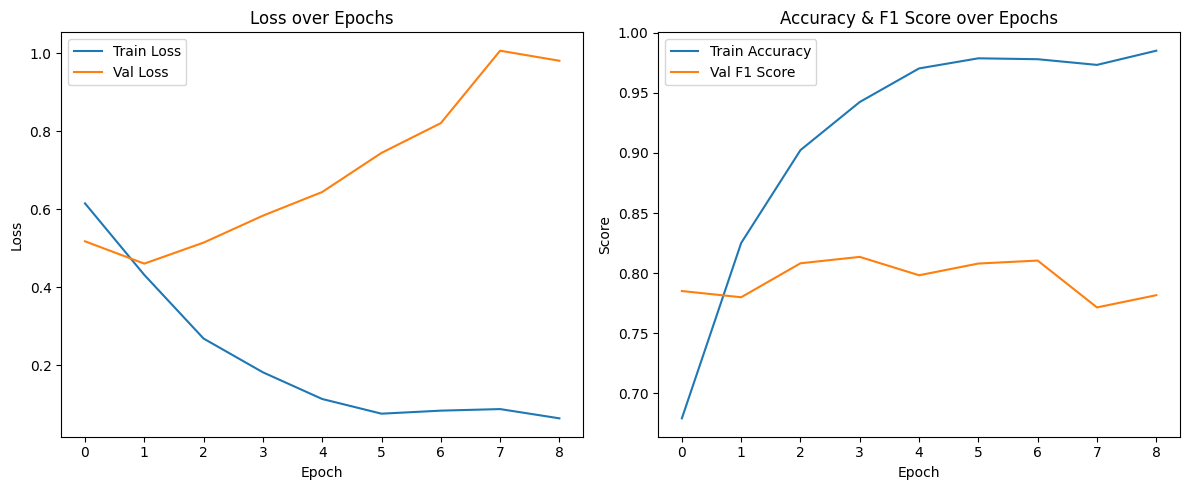

In [20]:
# Call the function to train the model
model, best_f1 = train_model(model, train_loader, val_loader, device, num_epochs=50, patience=5)


In [ ]:
# torch.save(model.state_dict(), "/kaggle/working/bert_v1.pth")
# model.load_state_dict(torch.load('/kaggle/working/bert_v1.pth'))

# Predict test data

In [21]:
def tokenize_test(tokenizer, comments, max_length=128):
    input_ids, attention_masks = [], []
    for comment in comments:
        enc = tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            truncation=True,
            max_length=max_length,
            padding="max_length",
            return_attention_mask=True,
            return_tensors="pt",
        )
        input_ids.append(enc["input_ids"])
        attention_masks.append(enc["attention_mask"])
    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)

test_input_ids, test_attention_masks = tokenize_test(tokenizer, test_df["body"], max_length=128)
test_dataset = TensorDataset(test_input_ids, test_attention_masks)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [22]:
def predict(model, loader, device):
    model.eval()
    all_preds = []
    all_probs = []
    
    with torch.no_grad():
        for batch in loader:
            input_ids, attention_mask = [t.to(device) for t in batch]
            
            output = model(input_ids=input_ids, attention_mask=attention_mask)

            logits = output.logits.squeeze(-1)
            probs = torch.sigmoid(logits)
            all_probs.extend(probs.cpu().tolist())
            
    return all_probs

res = predict(model, test_loader, device)

In [23]:
res

[0.12855780124664307,
 0.9759647250175476,
 0.9728960990905762,
 0.9799021482467651,
 0.9426663517951965,
 0.03150252252817154,
 0.9702237844467163,
 0.01809854432940483,
 0.0369974710047245,
 0.9755038022994995]

In [24]:
submission = pd.DataFrame(test_df["row_id"])
submission["rule_violation"] = res

In [25]:
submission

,row_id,rule_violation
0,2029,0.128558
1,2030,0.975965
2,2031,0.972896
3,2032,0.979902
4,2033,0.942666
5,2034,0.031503
6,2035,0.970224
7,2036,0.018099
8,2037,0.036997
9,2038,0.975504


In [ ]:
submission.to_csv('submission.csv', index=False)